# Introduction

## Lab2: Train a Convolutional Neural Network (CNN).

In this Lab session we will learn how to train a CNN from scratch for classifying MNIST digits.

In [47]:
# import necessary libraries
import torch
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F

### Define LeNet

![network architecture](https://www.researchgate.net/profile/Lucijano-Berus/publication/329891470/figure/fig1/AS:707347647307776@1545656229128/Architecture-of-LeNet-5-a-Convolutional-Neural-Network-for-digits-digits-recognition-An.ppm)

Here we are going to define our first CNN which is **LeNet** in this case. This architecture has been introduced and is detailed in [this article](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). To construct a LeNet we will be using some convolutional layers followed by some fully-connected layers. The convolutional layers can be simply defined using `torch.nn.Conv2d` module of `torch.nn` package. Details can be found [here](https://pytorch.org/docs/stable/nn.html#conv2d). Moreover, we will use pooling operation to reduce the size of convolutional feature maps. For this case we are going to use `torch.nn.functional.max_pool2d`. Details about maxpooling can be found [here](https://pytorch.org/docs/stable/nn.html#max-pool2d)

Differently from our previous Lab, we will use a Rectified Linear Units (ReLU) as activation function with the help of `torch.nn.functional.relu`, replacing `torch.nn.Sigmoid`. Details about ReLU can be found [here](https://pytorch.org/docs/stable/nn.html#id26).

In [48]:
class LeNet(torch.nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    
    # input channel = ?, output channels = ?, kernel size = ?
    # input image size = (?, ?), image output size = (?, ?)
    # TODO

    input_chanel = 1
    output_chanel = 6   #6 features map 
    kernel_size = (5,5) #5*5 neighborhood in the input 
    self.C1 = torch.nn.Conv2d(input_chanel, output_chanel, kernel_size, stride=1, padding=1)
    # resize 32*32 pour centrer l'image ?

    # input channel = ?, output channels = ?, kernel size = ?
    # input image size = (?, ?), output image size = (?, ?)
    # TODO
    input_chanel = 6 #fixed by input chanel
    output_chanel = 16 #C3 in the scheme above
    kernel_size = (5,5) # each feature map is connected to several 5x5 neighborhoods
    self.C3 = torch.nn.Conv2d(input_chanel, output_chanel, kernel_size, stride=1, padding=1)


    #Now we copy the values of the scheme above
    # input dim = ?, output dim = ?
    # TODO
    input_dim = 16*5*5
    output_dim = 120
    self.S4=torch.nn.Linear(input_dim,output_dim)
        
    # input dim = ? ( H x W x C), output dim = ?
    # TODO
    input_dim = 120
    output_dim = 84
    self.S5=torch.nn.Linear(input_dim,output_dim)
    
    # input dim = ?, output dim = ?
    # TODO
    input_dim = 84
    output_dim = 10
    self.F6=torch.nn.Linear(input_dim,output_dim)
    
  def forward(self, x):
    
    # TODO
    # Max Pooling with kernel size = ?
    # output size = (?, ?)
    # TODO
    x=self.C1(x)
    division=2
    x=torch.nn.MaxPool2d(division)(x)
    x=torch.nn.ReLU()(x)
    output_size=(14,14)
    
    # TODO
    # Max Pooling with kernel size = ?
    # output size = (?, ?)
    # TODO
    x=self.C3(x)
    division=2
    x=torch.nn.MaxPool2d(division)(x)
    x=torch.nn.ReLU()(x)
    output_size = (10,10) 
    
    
    # flatten the feature maps into a long vector
    x = x.view(x.shape[0], -1)
    
    # TODO
    x= self.S4(x)
    x=torch.nn.ReLU()(x)
    # TODO
    x= self.S5(x)
    x=torch.nn.ReLU()(x)
    # TODO
    x=self.F6(x)
    return x

### Define cost function

In [49]:
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

### Define the optimizer

We will use SGD with learning rate-lr, weight_decay=wd and  momentum=momentum 

In [50]:
def get_optimizer(net, lr, wd, momentum):
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=momentum)
  return optimizer

### Train and test functions

In [51]:
def test(net, data_loader, cost_function, device='cpu'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  net.eval() # Strictly needed if network contains layers which has different behaviours between train and test
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)
        
      # Forward pass
      outputs = net(inputs)

      # Apply the loss
      loss = cost_function(outputs, targets)

      # Better print something
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100


def train(net,data_loader,optimizer,cost_function, device='cpu'):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  
  net.train() # Strictly needed if network contains layers which has different behaviours between train and test
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # Load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)
      
    # Forward pass
    outputs = net(inputs)

    # Apply the loss
    loss = cost_function(outputs,targets)

    # Reset the optimizer
      
    # Backward pass
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    optimizer.zero_grad()

    # Better print something, no?
    samples+=inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(1)
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

### Define the function that fetches a data loader that is then used during iterative training.

We will learn a new thing in this function as how to Normalize the inputs given to the network.

***Why Normalization is needed***? 

To have nice and stable training of the network it is recommended to normalize the network inputs between \[-1, 1\]. 

***How it can be done***? 

This can be simply done using `torchvision.transforms.Normalize()` transform. Details can be found [here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize).

In [52]:
def get_data(batch_size, test_batch_size=256):
  
  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  full_training_data = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True) 
  test_data = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True) 
  

  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)
  
  return train_loader, val_loader, test_loader

### Wrapping everything up

Finally, we need a main function which initializes everything + the needed hyperparameters and loops over multiple epochs (printing the results).

In [53]:
'''
Input arguments
  batch_size: Size of a mini-batch
  device: GPU where you want to train your network
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main(batch_size=128, 
         device='cpu', 
         learning_rate=0.01, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=20):
  
  train_loader, val_loader, test_loader = get_data(batch_size)
  
  # TODO for defining LeNet-5 
  net = LeNet()
  
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  
  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')


  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')

Lets train!

In [54]:
main()

Before training:
	 Training loss 0.01805, Training accuracy 9.64
	 Validation loss 0.00906, Validation accuracy 9.41
	 Test loss 0.00922, Test accuracy 9.60
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00926, Training accuracy 60.29
	 Validation loss 0.00077, Validation accuracy 94.01
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00112, Training accuracy 95.62
	 Validation loss 0.00039, Validation accuracy 96.94
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00073, Training accuracy 97.06
	 Validation loss 0.00031, Validation accuracy 97.59
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00056, Training accuracy 97.73
	 Validation loss 0.00025, Validation accuracy 98.05
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00045, Training accuracy 98.19
	 Validation loss 0.00022, Validation accuracy 98.21
------------------

Using the proper metric from sklearn, check which character is most frequently confused with which: can you explain why ?



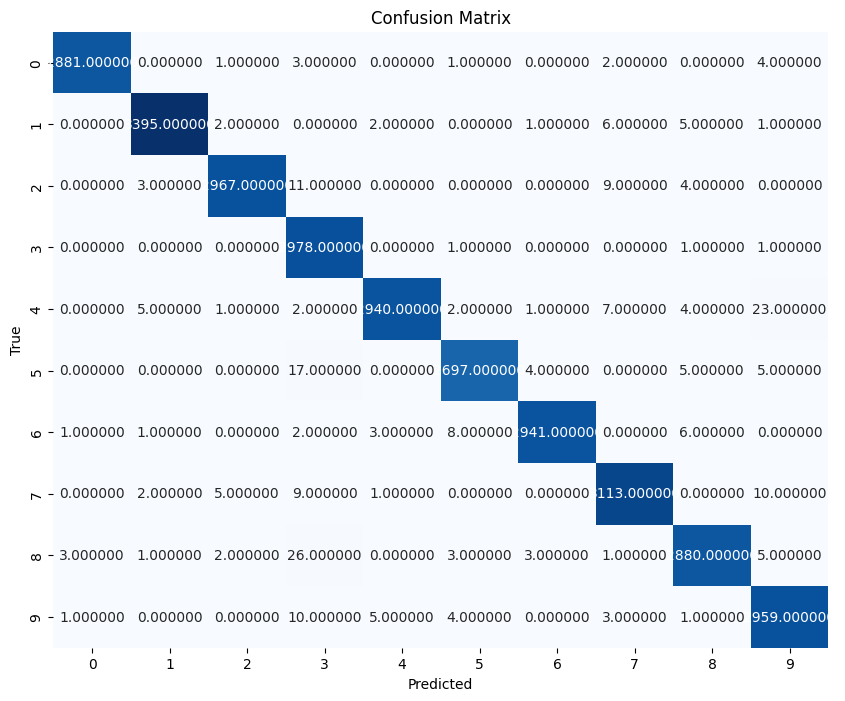

In [55]:
# TEST
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
def main2(batch_size=128, 
         device='cpu', 
         learning_rate=0.01, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=10):
  
  train_loader, val_loader, test_loader = get_data(batch_size)
  
  # TODO for defining LeNet-5 
  net = LeNet()
  
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  
  cost_function = get_cost_function()

  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)




  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)

  # we estimate that the model is now trained and we want to get the predicited values : 
  predicted = []
  data_loader = train_loader
  cm=np.zeros((10,10))
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)
          
      # Forward pass
      outputs = net(inputs)
      _, pred=outputs.max(1)
      cm+=confusion_matrix(pred,targets)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt="f", cmap="Blues", cbar=False)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.show()

main2()


  

It seems that my model tends to confuse the 7 and the 9 if I only train on 1 epoch

If I train on a second epoch, my model confuses less 7 and 9 but confuses 7 and 9 and 4 and 9.

If I train it over 10 epochs, it only confuses between 8 and 9, which could be expected as they are similar numbers.

The LeNet5 architecture can also be implemented using the sequential API ([see documentation ](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)). Reimplement it with this API.

In [56]:
class LeNet5(torch.nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 6, (5,5), stride=1, padding=1),
        torch.nn.MaxPool2d(2),
        torch.nn.ReLU(),
        torch.nn.Conv2d(6, 16, (5,5), stride=1, padding=1),
        torch.nn.MaxPool2d(2),
        torch.nn.ReLU(),
        torch.nn.Flatten(),
        torch.nn.Linear(16*5*5,120),
        torch.nn.ReLU(),
        torch.nn.Linear(120,84),
        torch.nn.ReLU(),
        torch.nn.Linear(84,10)
    )
    
    
  def forward(self, x):
    x=self.model(x)
    return x

##Experiments


* Implement adaptive early stopping: if the validation loss did not decrease for K consecutive epochs, stop training.
* Change dataset in order to evaluate the LeNet5 network on cifar10 dataset. You can have a look at the pytorch documentation to easily access the cifar10 dataset. 
* Try to improve performance with:
   *   data-augmentation
   *   dropout
* Implement the resnet18 architecture using the Resnet18 class from pytorch.





In [57]:
#adaptative early stopping
K =3;
'''
Input arguments
  batch_size: Size of a mini-batch
  device: GPU where you want to train your network
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
'''

def main_early(batch_size=128, 
         device='cpu', 
         learning_rate=0.01, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=50):
  
  train_loader, val_loader, test_loader = get_data(batch_size)
  
  # TODO for defining LeNet-5 
  net = LeNet()
  
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  val_loss_list = []
  cost_function = get_cost_function()

  print('Before training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')


  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)

    val_loss, val_accuracy = test(net, val_loader, cost_function)
    val_loss_list.append(val_loss)
    print('Epoch: {:d}'.format(e+1))
    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')
    if e > K:
      if val_loss_list[-1]>=val_loss_list[e-K]:
        break

  print('After training:')
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)

  print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\t Validation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')
main_early()


Before training:
	 Training loss 0.01806, Training accuracy 9.61
	 Validation loss 0.00907, Validation accuracy 10.11
	 Test loss 0.00923, Test accuracy 9.58
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00966, Training accuracy 61.29
	 Validation loss 0.00093, Validation accuracy 92.84
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00120, Training accuracy 95.37
	 Validation loss 0.00046, Validation accuracy 96.52
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00072, Training accuracy 97.22
	 Validation loss 0.00038, Validation accuracy 97.07
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00055, Training accuracy 97.87
	 Validation loss 0.00030, Validation accuracy 97.63
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00046, Training accuracy 98.15
	 Validation loss 0.00029, Validation accuracy 97.73
-----------------

CIFAR

In [58]:
#first get the data
def get_data_cifar(batch_size, test_batch_size=256):
  
  # Prepare data transformations and then combine them sequentially
  transform = list()
  transform.append(T.ToTensor())                            # converts Numpy to Pytorch Tensor
  transform.append(T.Normalize(mean=[0.5], std=[0.5]))      # Normalizes the Tensors between [-1, 1]
  transform = T.Compose(transform)                          # Composes the above transformations into one.

  # Load data
  full_training_data = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True) 
  test_data = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True) 
  

  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)
  
  return train_loader, val_loader, test_loader



In [59]:
#as the input is  different, the LeNet class changes a bit
class LeNet5_cifar(torch.nn.Module):
  def __init__(self):
    super(LeNet5_cifar, self).__init__()
    self.model = torch.nn.Sequential(
        torch.nn.Conv2d(3, 6, (5,5), stride=1, padding=1),
        torch.nn.Conv2d(6, 16, (5,5), stride=1, padding=1),
        torch.nn.Flatten(),
        torch.nn.Linear(12544,120),#576
        torch.nn.Linear(120,84),
        torch.nn.Linear(84,10)
    )
    
    
  def forward(self, x):
    x=self.model(x)
    return x


Files already downloaded and verified
Files already downloaded and verified


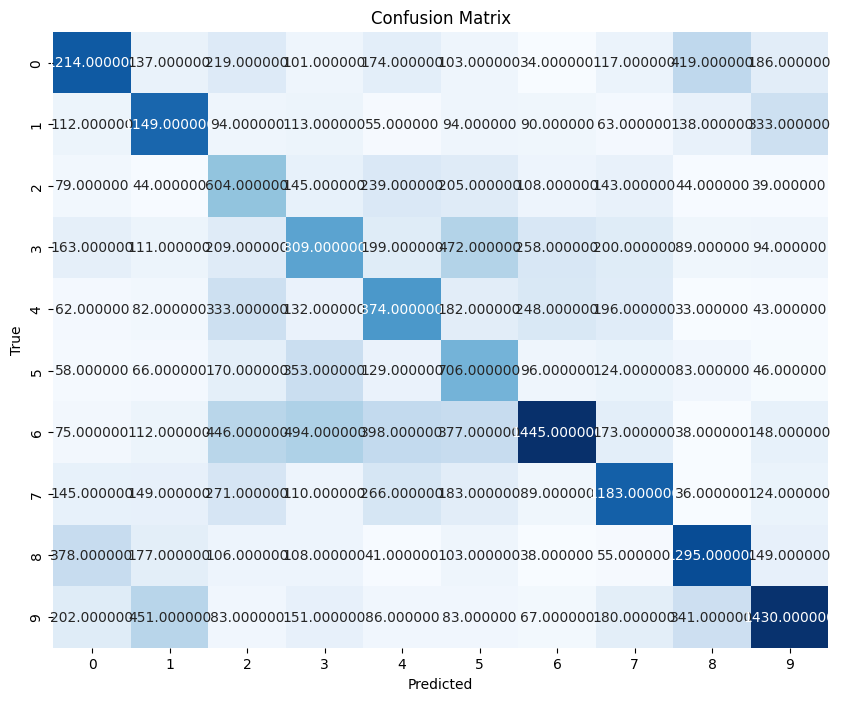

In [60]:
#Then we change the main to plo the confusion matrix
def cifar_cm(dropout, batch_size=128, 
         device='cpu', 
         learning_rate=0.01, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=5):
  
  train_loader, val_loader, test_loader = get_data_cifar(batch_size)
  
  # TODO for defining LeNet-5 
  if (dropout):
    net = LeNet5_cifar()
  else :
    net = LeNet5_dropout()
  
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  
  cost_function = get_cost_function()

  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)




  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)

  # we estimate that the model is now trained and we want to get the predicited values : 
  predicted = []
  data_loader = train_loader
  cm=np.zeros((10,10))
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)
          
      # Forward pass
      outputs = net(inputs)
      _, pred=outputs.max(1)
      cm+=confusion_matrix(pred,targets)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt="f", cmap="Blues", cbar=False)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.show()

cifar_cm(True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


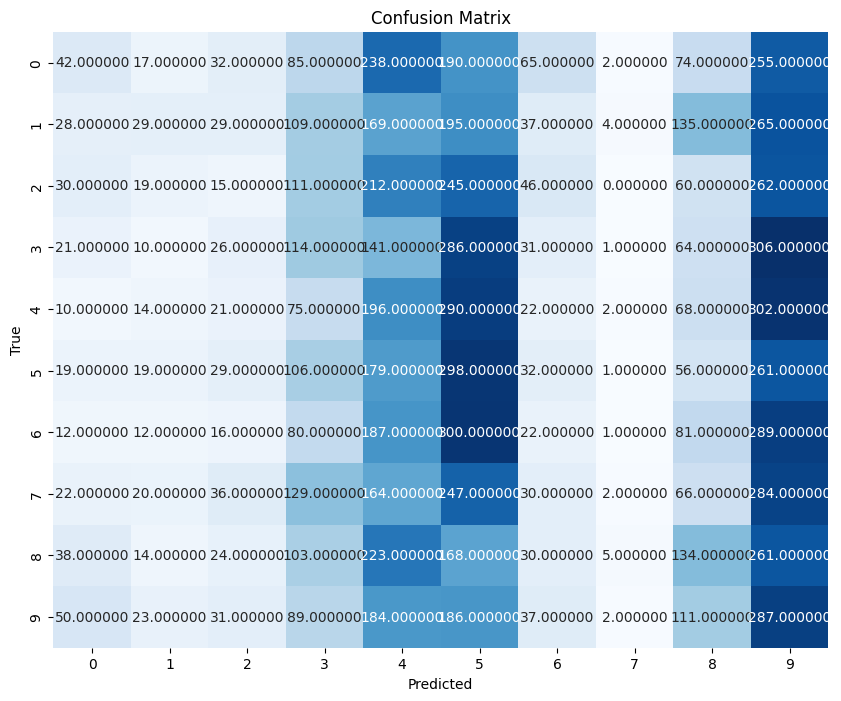

In [65]:
##### DATA AUGMENTATION #####

def get_data_cifar_augmentation(batch_size, test_batch_size=256):
  
  # Prepare data transformations and then combine them sequentially
                         # Composes the above transformations into one.
  transform_train = T.Compose([
      T.RandomCrop(32, padding=4),
      T.RandomHorizontalFlip(),
      T.RandomPosterize(bits=4),#I chose arbitrarly some transformations
      T.ElasticTransform(),
      T.RandomInvert(),
      T.ToTensor(),
      T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])

  transform_test = T.Compose([
      T.ToTensor(),
      T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])

  train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
  val_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)
  test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)


  # Load data
  full_training_data = torchvision.datasets.CIFAR10('./data', train=True, transform=transform_train, download=True) 
  test_data = torchvision.datasets.CIFAR10('./data', train=False, transform=transform_train, download=True) 
  

  # Create train and validation splits
  num_samples = len(full_training_data)
  training_samples = int(num_samples*0.5+1)
  validation_samples = num_samples - training_samples

  training_data, validation_data = torch.utils.data.random_split(full_training_data, [training_samples, validation_samples])

  # Initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)
  
  return train_loader, val_loader, test_loader

def cifar_cm_augmentation(batch_size=128, 
         device='cpu', 
         learning_rate=0.01, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=1):
  
  train_loader, val_loader, test_loader = get_data_cifar_augmentation(batch_size)
  
  # TODO for defining LeNet-5 
  net = LeNet5_cifar()
  
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)
  
  cost_function = get_cost_function()

  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)




  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)

  # we estimate that the model is now trained and we want to get the predicited values : 
  predicted = []
  data_loader = train_loader
  cm=np.zeros((10,10))
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)
          
      # Forward pass
      outputs = net(inputs)
      _, pred=outputs.max(1)
      cm+=confusion_matrix(targets, pred)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt="f", cmap="Blues", cbar=False)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.show()


cifar_cm_augmentation()

I can't tell why but the data augmentation does not seem to be working....

DROPOUT

In [62]:
## We have to code once again the sequential class :
class LeNet5_dropout(torch.nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.model = torch.nn.Sequential(
        torch.nn.Conv2d(3, 6, (5,5), stride=1, padding=1),
        torch.nn.MaxPool2d(2),
        torch.nn.ReLU(),
        torch.nn.Conv2d(6, 16, (5,5), stride=1, padding=1),
        torch.nn.MaxPool2d(2),
        torch.nn.ReLU(),
        torch.nn.Flatten(),
        torch.nn.Linear(576,120),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.5),
        torch.nn.Linear(120,84),
        torch.nn.ReLU(),
        torch.nn.Linear(84,10)
    )
    
    
  def forward(self, x):
    x=self.model(x)
    return x

Files already downloaded and verified
Files already downloaded and verified


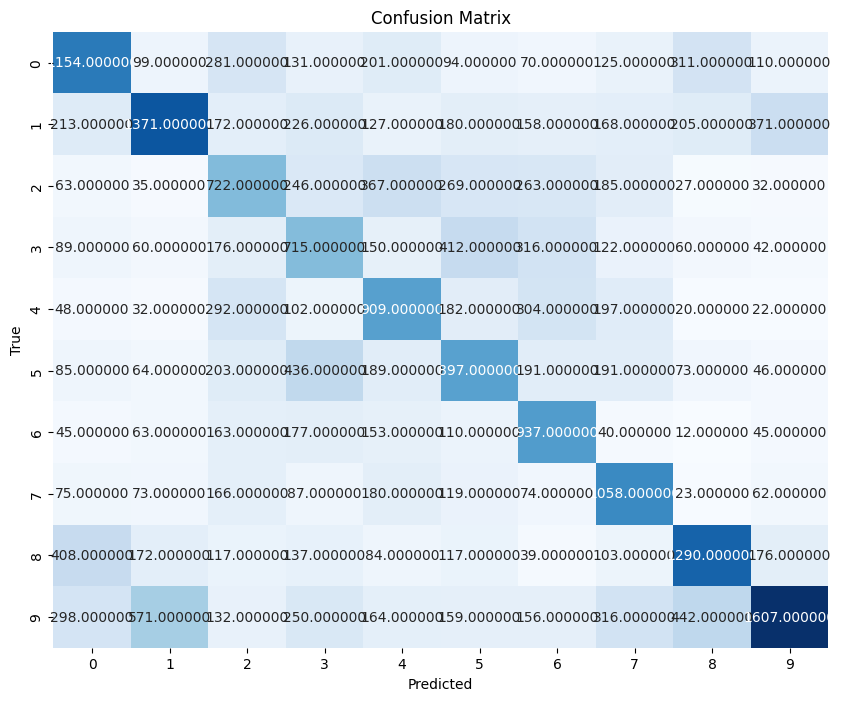

In [63]:
#confsuion matrix after dropout
cifar_cm(True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


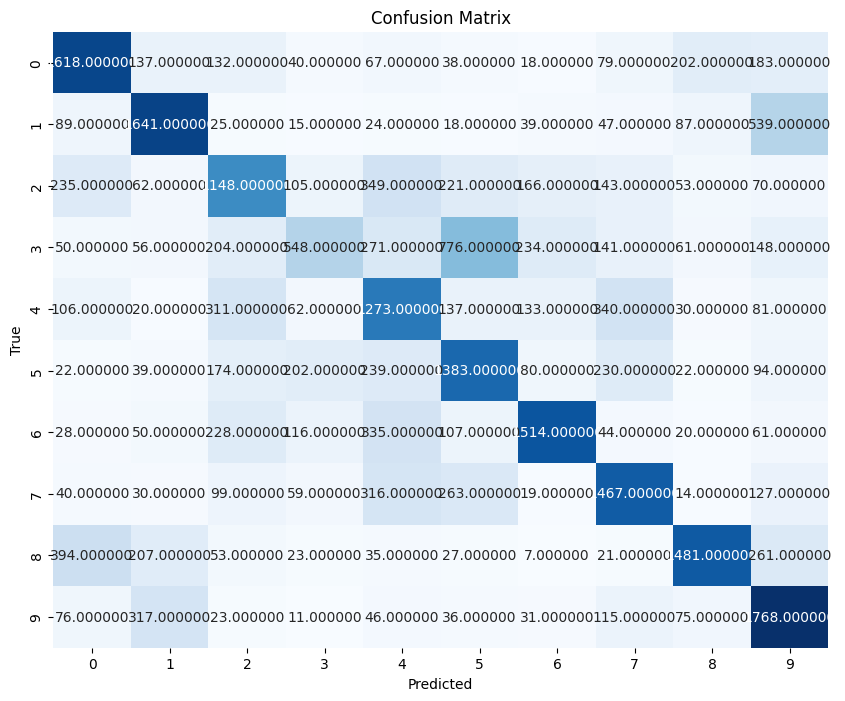

In [70]:
#resnet
def Resnet18(batch_size=128, 
         device='cpu', 
         learning_rate=0.01, 
         weight_decay=0.000001, 
         momentum=0.9, 
         epochs=3,
         K=2):
  
  train_loader, val_loader, test_loader = get_data_cifar_augmentation(batch_size)
   
  net = torchvision.models.resnet18().to(device)
  optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

  cost_function = get_cost_function()
  train_loss, train_accuracy = test(net, train_loader, cost_function)
  val_loss, val_accuracy = test(net, val_loader, cost_function)
  test_loss, test_accuracy = test(net, test_loader, cost_function)




  for e in range(epochs):
    train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)

  # we estimate that the model is now trained and we want to get the predicited values : 
  predicted = []
  data_loader = train_loader
  cm=np.zeros((10,10))
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
      # Load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)
          
      # Forward pass
      outputs = net(inputs)
      _, pred=outputs.max(1)
      cm+=confusion_matrix(targets, pred)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt="f", cmap="Blues", cbar=False)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.show()

Resnet18()
